In [ ]:
## Since my computer's main drive is actually on a secondary drive, all paths could not be relative and had to be directed 
## to include the right hard drive. Please modify your code as such to work with respect to the folder and computer

## Imports and Method Definitions

In [1]:
# For Sliding Window
from skimage.transform import pyramid_gaussian
from skimage import color
from imutils.object_detection import non_max_suppression
import imutils
import time

In [2]:
carSize = (800, 800) # resize of car images

In [5]:
import random
import glob
import xml.etree.ElementTree as ET
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Test method for logic
def parseXML(file):
    root = file.getroot()
    folder = root.find('folder').text
    width = root.find('size/width').text
    objectType = root.find('object/bndbox').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)
    size = [width, height, depth]
    return folder, width, objectType, size

# Parse car images and xml from DIR
def parseXMLtoDF_Region(osDIR):
    #Setup our DF
    d = {'filename':[], 'filepath':[], 'size':[],
     'objectType':[], 'bndbox':[], 'image':[]}
    df = pd.DataFrame(data=d)
    
    os.chdir(osDIR)
    dirlist = os.listdir()
    #filenames = glob.glob("[0-99]*.xml")  # change the pattern to match your case
    filenames = glob.glob(osDIR + '\*.xml', recursive = True)
    
    for filename in filenames:
        with open(filename, 'r', encoding="utf-8") as content:
            file = ET.parse(content)
            root = file.getroot()
            
            filename = root.find('filename').text
            imgDIR = osDIR + '\\' + filename
            img = plt.imread(imgDIR)
            #img = color.rgb2gray(img) ## COMMENT OR UNCOMMENT THIS --------------------
            filepath = imgDIR
            
            width = int(root.find('size/width').text)
            height = int(root.find('size/height').text)
            depth = int(root.find('size/depth').text)
            size = [width, height, depth]
            
            objectType = root.find('object/name').text
            xmin = int(root.find('object/bndbox/xmin').text)
            xmax = int(root.find('object/bndbox/xmax').text)
            ymin = int(root.find('object/bndbox/ymin').text)
            ymax = int(root.find('object/bndbox/ymax').text)
            
            bndbox = [xmin, ymin, xmax, ymax]
            img = cv2.resize(img, carSize) #img size change

            x_alter = carSize[0]/width # compression or expansion rate in x axis (expansion in our case, because we went up in x axis, from 333 to 800)
            y_alter = carSize[1]/height # compression or expansion rate in y axis (expansion in our case, because we went up in x axis, from 500 to 800)

            #print(x_alter, y_alter)

            # compress or expand ground truth box accordinly
            bndbox[0] = int(bndbox[0] * x_alter)
            bndbox[1] = int(bndbox[1] * y_alter)
            bndbox[2] = int(bndbox[2] * x_alter)
            bndbox[3] = int(bndbox[3] * y_alter)

            

            df2 = {'filename': filename, 'filepath': filepath, 'size': size,
             'objectType': objectType, 'bndbox': bndbox, 'image': img}
            df = df.append(df2, ignore_index = True)
    return df


# Parse Logo and Xml from DIR
def parseXMLtoDF_Logo(osDIR):
    #Setup our DF
    d = {'filename':[], 'filepath':[], 'size':[],
     'objectType':[], 'bndbox':[], 'bndbox_img':[]}
    df = pd.DataFrame(data=d)
    
    os.chdir(osDIR)
    dirlist = os.listdir()
    #filenames = glob.glob("[0-99]*.xml")  # change the pattern to match your case
    filenames = glob.glob(osDIR + '\*.xml', recursive = True)
    
    for filename in filenames:
        with open(filename, 'r', encoding="utf-8") as content:
            file = ET.parse(content)
            root = file.getroot()
            
            filename = root.find('filename').text
            imgDIR = osDIR + '\\' + filename
            img = plt.imread(imgDIR)
            #img = color.rgb2gray(img) ## COMMENT OR UNCOMMENT THIS --------------------
            filepath = imgDIR
            
            width = int(root.find('size/width').text)
            height = int(root.find('size/height').text)
            depth = int(root.find('size/depth').text)
            size = [width, height, depth]
            
            objectType = root.find('object/name').text
            if(objectType == 'toyota'):
                objectType = 'Toyota'
            elif(objectType == 'Chevorlet'):
                objectType = 'Chevrolet'
            elif(objectType == 'Hyundai-2'):
                objectType = 'Hyundai'
            elif(objectType == 'vw'):
                objectType = 'Volkswagen'
            xmin = int(root.find('object/bndbox/xmin').text)
            xmax = int(root.find('object/bndbox/xmax').text)
            ymin = int(root.find('object/bndbox/ymin').text)
            ymax = int(root.find('object/bndbox/ymax').text)
            
            bndbox = [xmin, ymin, xmax, ymax]

            startX, startY, endX, endY = bndbox
            bb_img = img[int(startY):int(endY), int(startX):int(endX)]
            bb_img = cv2.resize(bb_img, trainingSize) #img size change

            df2 = {'filename': filename, 'filepath': filepath, 'size': size,
             'objectType': objectType, 'bndbox': bndbox, 'bndbox_img': bb_img}
            df = df.append(df2, ignore_index = True)
    return df

# Output for DataFrame
def displayBNDBOXinDF(df):
    counter = 0
    approxRows = int(df['bndbox_img'].count() / 5)
    #print(approxRows)
    bndbox_imgs = df['bndbox_img'].tolist()

    # Setup plot
    fig, axes = plt.subplots(approxRows, 5, figsize=(10,10))
    axes = np.ndarray.flatten(axes)

    # Plot images
    for ax, im in zip(axes, bndbox_imgs):
        ax.set_xlabel(counter)
        ax.imshow(im)
        counter += 1

In [4]:
# HOG Prediction, either SGD or LinearSVM based off code further down
def testImage(path):
    img = plt.imread(path)
    img = cv2.resize(img, trainingSize)
    plt.imshow(img)
    fd, hog_image = hog(img, orientations=9, 
                            pixels_per_cell=(8,8),cells_per_block=(2,2), 
                            block_norm= 'L2', visualize=True)
    print(le.inverse_transform(svm.predict([fd])))
    print(svm.decision_function([fd]))
    print(np.argmax(svm.decision_function([fd])[0]))
    print(svm.decision_function([fd])[0][np.argmax(svm.decision_function([fd])[0])])

# CNN Prediction using Hog Images
def testImageCNN(path):
    img = plt.imread(path)
    img = cv2.resize(img, trainingSize)
    plt.imshow(img)
    fd, hog_image = hog(img, orientations=9, 
                            pixels_per_cell=(8,8),cells_per_block=(2,2), 
                            block_norm= 'L2', visualize=True)
    #print(le.inverse_transform(np.argmax(cnn.predict(np.array([hog_image,])))))
    print(cnn.predict(np.array([hog_image,])))  #[0]
    pred = np.argmax(cnn.predict(np.array([hog_image,])))
    print(pred)
    print(le.inverse_transform([int(pred),]))
    
# Pick a random car from car DF and shows bndbox    
def testRegionImage(df):
    value = random.randint(0, df['image'].count()-1)
    print("Image number: "+str(value))
    image = df['image'].iloc[value]
    bbox = df['bndbox'].iloc[value]
    xmin, ymin, xmax, ymax = bbox
    img_ = np.copy(image)
    cv2.rectangle(img = img_, pt1 = (xmin, ymin), pt2 = (xmax, ymax), color = (0,255,0), thickness = 2)
    cv2.imshow("img", img_)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Import all Classes (7)

In [6]:
path = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Lamborghini"
carLamborghiniDF = parseXMLtoDF_Region(path)
testRegionImage(carLamborghiniDF)
carLamborghiniDF.info()

Image number: 26
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    47 non-null     object
 1   filepath    47 non-null     object
 2   size        47 non-null     object
 3   objectType  47 non-null     object
 4   bndbox      47 non-null     object
 5   image       47 non-null     object
dtypes: object(6)
memory usage: 2.3+ KB


In [8]:
path = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\BMW"
carBMWDF = parseXMLtoDF_Region(path)
testRegionImage(carBMWDF)
carBMWDF.info()

Image number: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    47 non-null     object
 1   filepath    47 non-null     object
 2   size        47 non-null     object
 3   objectType  47 non-null     object
 4   bndbox      47 non-null     object
 5   image       47 non-null     object
dtypes: object(6)
memory usage: 2.3+ KB


In [9]:
path = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Toyota"
carToyotaDF = parseXMLtoDF_Region(path)
testRegionImage(carToyotaDF)
carToyotaDF.info()

Image number: 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    50 non-null     object
 1   filepath    50 non-null     object
 2   size        50 non-null     object
 3   objectType  50 non-null     object
 4   bndbox      50 non-null     object
 5   image       50 non-null     object
dtypes: object(6)
memory usage: 2.5+ KB


In [11]:
path = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Chevrolet"
carChevroletDF = parseXMLtoDF_Region(path)
testRegionImage(carChevroletDF)
carChevroletDF.info()

Image number: 41
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    52 non-null     object
 1   filepath    52 non-null     object
 2   size        52 non-null     object
 3   objectType  52 non-null     object
 4   bndbox      52 non-null     object
 5   image       52 non-null     object
dtypes: object(6)
memory usage: 2.6+ KB


In [12]:
path = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Benz"
carBenzDF = parseXMLtoDF_Region(path)
testRegionImage(carBenzDF)
carBenzDF.info()

Image number: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    54 non-null     object
 1   filepath    54 non-null     object
 2   size        54 non-null     object
 3   objectType  54 non-null     object
 4   bndbox      54 non-null     object
 5   image       54 non-null     object
dtypes: object(6)
memory usage: 2.7+ KB


In [13]:
path = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Hyundai"
carHyundaiDF = parseXMLtoDF_Region(path)
testRegionImage(carHyundaiDF)
carHyundaiDF.info()

Image number: 31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    51 non-null     object
 1   filepath    51 non-null     object
 2   size        51 non-null     object
 3   objectType  51 non-null     object
 4   bndbox      51 non-null     object
 5   image       51 non-null     object
dtypes: object(6)
memory usage: 2.5+ KB


In [14]:
path = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Volkswagon"
carVolkswagenDF = parseXMLtoDF_Region(path)
testRegionImage(carVolkswagenDF)
carVolkswagenDF.info()

Image number: 33
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    54 non-null     object
 1   filepath    54 non-null     object
 2   size        54 non-null     object
 3   objectType  54 non-null     object
 4   bndbox      54 non-null     object
 5   image       54 non-null     object
dtypes: object(6)
memory usage: 2.7+ KB


In [15]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [16]:
combinedRegionDF = pd.concat([carBMWDF, carBenzDF, carChevroletDF, carHyundaiDF, carLamborghiniDF, carToyotaDF, carVolkswagenDF])

## Testing Selective Search on Image

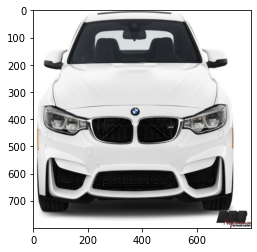

In [17]:
plt.imshow(combinedRegionDF['image'].iloc[0])

In [18]:
# Method to check every image present in dataframe
def checkAllRegions(df):
    for value in range(len(df)):
        #print("Image number: "+str(value))
        image = df['image'].iloc[value]
        filename = df['filename'].iloc[value]
#         print(image.shape)
#         print(filename)
        bbox = df['bndbox'].iloc[value]
        xmin, ymin, xmax, ymax = bbox
        img_ = np.copy(image)
        cv2.rectangle(img = img_, pt1 = (xmin, ymin), pt2 = (xmax, ymax), color = (0,255,0), thickness = 2)
        cv2.imshow(("Image number: "+str(value)), img_)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [19]:
combinedRegionDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 0 to 53
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    355 non-null    object
 1   filepath    355 non-null    object
 2   size        355 non-null    object
 3   objectType  355 non-null    object
 4   bndbox      355 non-null    object
 5   image       355 non-null    object
dtypes: object(6)
memory usage: 19.4+ KB


In [20]:
checkAllRegions(combinedRegionDF)

In [20]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() #create our selective search

In [21]:
# Test on the provided singular image in folder TEST
path = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\TEST"
carTESTDF = parseXMLtoDF_Region(path)
img = np.copy(carTESTDF['image'].iloc[0])
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# Show the true logo bndbox on the car
bndbox_img = carTESTDF['bndbox'].iloc[0]
xmin, ymin, xmax, ymax = bndbox_img
img_ = np.copy(img)
cv2.rectangle(img = img_, pt1 = (xmin, ymin), pt2 = (xmax, ymax), color = (0,255,0), thickness = 2)
cv2.imshow('img', img_)
cv2.waitKey(0)
cv2.destroyAllWindows()

5366


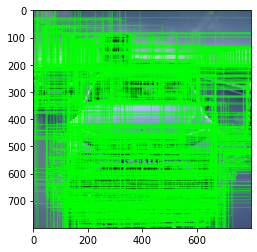

In [23]:
# Test to see all selective search results
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = img.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)
print(i)

In [24]:
# IOU method provided from the Faster RCNN implementation attempted
def IOU(box1, box2):    
    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    
    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0
    
    # ------computing union------
    # sum of area of both the boxes - area_overlap
    
    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])
    
    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])
    
    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2
    
    # union
    area_union = area_union_overlap - area_overlap
    
    # compute IOU
    iou = area_overlap/ area_union
    
    return iou

In [25]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [27]:
# Grabbing our images
train_images = np.stack(combinedRegionDF.image.values,axis=0)
print(train_images.shape)

(355, 800, 800, 3)


In [28]:
# Grabbing the logos bndboxs for images
train_bndbox = np.stack(combinedRegionDF.bndbox.values,axis=0)
print(train_bndbox.shape)

(355, 4)


In [29]:
# Append to later
X_images = []
X_labels = []

In [30]:
# Test train_images
cv2.imshow('img', (train_images[0]).astype('uint8'))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [49]:
# bndbox = train_bndbox[0]
# xmin, ymin, xmax, ymax = bndbox
# plt.imshow(train_images[0][ymin:ymax,xmin:xmax])

In [50]:
# for i in range(len(train_images)):
#     cv2.imshow('img', train_images[i])
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

## Grabbing Our Data from the Training Images

In [31]:
c = 0
f = 0
for i in range(len(train_images)):
    # Grab Truths
    print(i)
    image = train_images[i]
    bndbox = train_bndbox[i]
    xmin, ymin, xmax, ymax = bndbox
    
    # Selective Search On Image
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()
    
    # Counters to track progress
    counter = 0
    falsecounter = 0
    flag = 0
    fflag = 0
    bflag = 0
    for e, result in enumerate(ssresults):
        if flag == 0: # as long as flag is good
            x,y,w,h = result
            iou = IOU(bndbox, (x, y, x+w, y+h))
            
            if counter < 5: #while positive counter is less than 25, typically only gets 1 positive match regardless
                if iou > 0.70:
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    X_images.append(resized)
#                     plt.figure()
#                     plt.imshow((resized).astype('uint8'))
                    X_labels.append(1)
                    counter += 1
            else :
                fflag = 1
                
            if falsecounter < 5: # get this many number of false regions
                if iou < 0.3:
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    X_images.append(resized)
#                     plt.figure()
#                     plt.imshow(resized.astype('uint8'))
                    X_labels.append(0)
                    falsecounter += 1
            else :
                bflag = 1
            if fflag == 1 and bflag == 1: # both conditions reached
                print("inside")
                flag = 1 # flag is called, no more need to append, loop through remaining results
    c += counter
    f += falsecounter

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
print(c)
print(f)

234
1775


In [33]:
X_new = np.array(X_images)
y_new = np.array(X_labels)

In [123]:
# Resulting X
X_new.shape

(2009, 224, 224, 3)

30
71
72
83


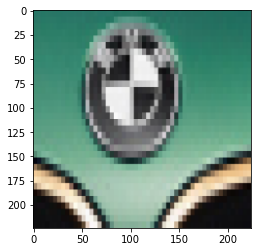

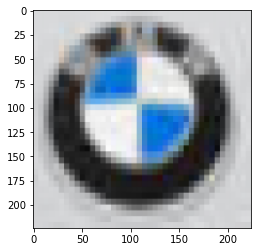

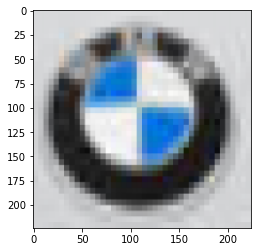

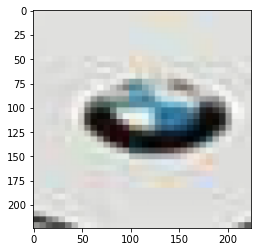

In [122]:
# Example images of logos within X_new
for i in range (100):
    pred = y_new[i]
    if pred == 1:
        print(i)
        plt.figure()
        plt.imshow(X_new[i].astype('uint8'))

## VGG16 Feature Extraction

In [35]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50 # tested, but did significantly worse model2moreimages2[deleted]

In [36]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [37]:
X = vggmodel.layers[-2].output # remove last 2 layers

In [38]:
predictions = Dense(2, activation="softmax")(X)  # replace layer with only softmax for 2 classes: yes logo, no logo

In [39]:
model_final = Model(vggmodel.input, predictions)
#model_final2 = Model(vggmodel.input, predictions)

In [40]:
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

D:\alexa\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Data Splitting

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [42]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [68]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
# convert to [0,1] syntax for training rcnn

In [69]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.3)

In [70]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1406, 224, 224, 3) (603, 224, 224, 3) (1406, 2) (603, 2)


In [79]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train, batch_size = 10) #limited extremely by batch size
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test, batch_size = 10)

In [80]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [81]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_ALL.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [82]:
hist = model_final.fit_generator(generator = traindata, steps_per_epoch = 20, epochs= 10, validation_data= testdata, validation_steps=10, callbacks=[checkpoint,early])
model_final.save(r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\TEST\model\modelALL")

Epoch 1/10
20/20 [==============================] - 6s 274ms/step - loss: 0.1862 - accuracy: 0.9550 - val_loss: 0.0629 - val_accuracy: 0.9600

Epoch 00001: val_loss improved from inf to 0.06291, saving model to ieeercnn_vgg16_ALL.h5
Epoch 2/10
20/20 [==============================] - 5s 243ms/step - loss: 0.1904 - accuracy: 0.9250 - val_loss: 0.1146 - val_accuracy: 0.9467

Epoch 00002: val_loss did not improve from 0.06291
Epoch 3/10
20/20 [==============================] - 5s 240ms/step - loss: 0.1275 - accuracy: 0.9600 - val_loss: 0.0780 - val_accuracy: 0.9733

Epoch 00003: val_loss did not improve from 0.06291
Epoch 4/10
20/20 [==============================] - 5s 247ms/step - loss: 0.1341 - accuracy: 0.9450 - val_loss: 0.1136 - val_accuracy: 0.9600

Epoch 00004: val_loss did not improve from 0.06291
Epoch 5/10
20/20 [==============================] - 5s 254ms/step - loss: 0.0560 - accuracy: 0.9800 - val_loss: 0.0780 - val_accuracy: 0.9733

Epoch 00005: val_loss did not improve from

## Importing Trained Model 

In [99]:
# Uncomment bottom line to load in the model
model_test = model_final
#model_test = keras.models.load_model(r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\TEST\model\modelALL")

In [100]:
train_labels = np.stack(combinedRegionDF.objectType.values,axis=0)
print(train_labels.shape)

(355,)


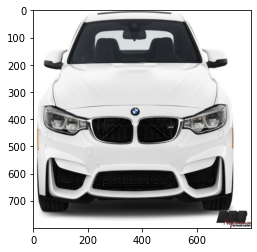

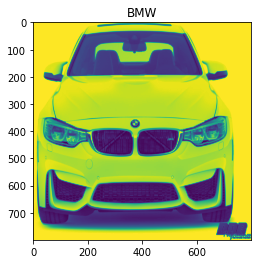

In [102]:
# Testing train_labels and train_images
plt.figure()
plt.imshow(train_images[0].astype('uint8'))
plt.figure()
plt.title(train_labels[0])
plt.imshow(color.rgb2gray(train_images[0]))

In [103]:
# Prediciton model for all 7 classes
cnnHOGwRegion = keras.models.load_model(r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\TEST\model\ALLcnnHOGwRegion")

In [104]:
# Dataframe associated with ALLcnnHOGwRegion
combinedDFwRegion = pd.read_csv(r'G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\ALLcombinedDFwRegion.csv')

In [105]:
combinedDFwRegion['objectType'].value_counts()

Toyota         136
Mercedes       135
BMW            133
Volkswagen     133
Chevrolet      132
Hyundai        130
Lamborghini    129
Name: objectType, dtype: int64

In [106]:
# Use label encoder to translate prediction
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
combinedDFwRegion['label'] = le.fit_transform(combinedDFwRegion.objectType)
combinedDFwRegion['label'].value_counts()

5    136
4    135
0    133
6    133
1    132
2    130
3    129
Name: label, dtype: int64

In [107]:
from skimage.feature import hog

['BMW']


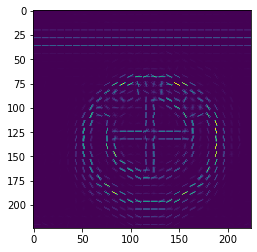

In [111]:
# Testing on an logo region of car to see if CNN works
t1 = color.rgb2gray(train_images[0][342:393, 346:400])
ROI = cv2.resize(t1, (224,224))
fd, hog_image = hog(ROI, orientations=9, 
                pixels_per_cell=(8,8), cells_per_block=(2,2), 
                block_norm= 'L2', visualize=True)
plt.imshow(hog_image)
pred = np.argmax(cnnHOGwRegion.predict(np.array([hog_image,])))
print(le.inverse_transform([pred,]))
truth = train_labels[0]
##print(le.inverse_transform([truth,]))

In [109]:
# how the bndbox was found
train_bndbox[0]

array([346, 342, 400, 393])

In [108]:
train_image_names = np.stack(combinedRegionDF.filename.values,axis=0)
print(train_image_names.shape)

(355,)


In [112]:
train_image_names[0]

'BMW_1.jpg'

## Testing

In [113]:
correct = 0
incorrect = 0
numpredictions = 0
for i in range(0, len(train_images), 2):
    # Grab truth
    image = train_images[i]
    bndbox_true = train_bndbox[i]
    label = train_labels[i]
    filename = train_image_names[i]
    
    # Output truth
    print("Image #: " + str(i) + " " + str(filename))
    print("\tTrue Bounding Boxes: " + str(bndbox_true))
    print("\tTrue Logo Present: " + str(label))
    
    # Selective search on image
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()
    
    # Append all predictions and rois
    predictions = []
    rois = []
    
    print("Image #" + str(i) + " Predictions:")
    for e, result in enumerate(ssresults):
        # look through all possible boxes instead of jsut 2000
        x,y,w,h = result
        xmax = x+w
        ymax = y+h
        timage = imout[y:y+h,x:x+w]
        #print(timage.shape)
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_test.predict(img) #predicted on the resized region of interest
        if out[0][0] > 0.70: #if passes threshold
            predictions.append(out[0][0])
            box = [x, y, xmax, ymax, (w, h)]
            rois.append(box)
    
    if(len(rois) == 0): # break statement if nothing passes threshold
        continue
        incorrect += 1
        numpredictions += 1
    
    best_pred = np.argmax(predictions) #predict on higehst confidence
    best_roi = rois[best_pred]
    x, y, xmax, ymax, (w, h) = best_roi
    
    ROI = cv2.resize(color.rgb2gray(imout[y:ymax, x:xmax]), (224,224)) #extract hog image and features
    fd, hog_image = hog(ROI, orientations=9, 
                    pixels_per_cell=(8,8), cells_per_block=(2,2), 
                    block_norm= 'L2', visualize=True)
    # fd = fd.reshape(1, -1)
    
    numpredictions += 1
    pred = np.argmax(cnnHOGwRegion.predict(np.array([hog_image,]))) #predict on the extracted hog image
    pred_english = le.inverse_transform([pred,])[0] #convert with labelencoder
    print('\t' + str(best_roi))
    print('\t' + pred_english)
    
    if(pred_english == label):
        correct += 1
    else:
        incorrect += 1
    
    
#     pred = svm.predict(fd)
#     pred_english = str(le.inverse_transform(pred)[0])
print("Total Predictions: " + str(numpredictions))
print("Correct: " + str(correct) + " \tIncorrect:" + str(incorrect))

Image #: 0 BMW_1.jpg
	True Bounding Boxes: [346 342 400 393]
	True Logo Present: BMW
Image #0 Predictions:
	[49, 534, 748, 741, (699, 207)]
	BMW
Image #: 2 BMW_11.jpeg
	True Bounding Boxes: [365 373 423 408]
	True Logo Present: BMW
Image #2 Predictions:
Image #: 4 BMW_13.jpeg
	True Bounding Boxes: [357 472 410 511]
	True Logo Present: BMW
Image #4 Predictions:
	[100, 489, 154, 539, (54, 50)]
	Toyota
Image #: 6 BMW_15.jpeg
	True Bounding Boxes: [349 490 408 540]
	True Logo Present: BMW
Image #6 Predictions:
	[33, 497, 735, 605, (702, 108)]
	Toyota
Image #: 8 BMW_17.jpeg
	True Bounding Boxes: [380 324 445 360]
	True Logo Present: BMW
Image #8 Predictions:
	[130, 403, 737, 659, (607, 256)]
	BMW
Image #: 10 BMW_19.jpeg
	True Bounding Boxes: [368 528 423 577]
	True Logo Present: BMW
Image #10 Predictions:
	[134, 152, 764, 782, (630, 630)]
	BMW
Image #: 12 BMW_20.jpeg
	True Bounding Boxes: [380 396 428 437]
	True Logo Present: BMW
Image #12 Predictions:
	[0, 0, 800, 800, (800, 800)]
	BMW
Ima

Image #106 Predictions:
	[0, 0, 95, 81, (95, 81)]
	Toyota
Image #: 108 Chevrolet_30.jpeg
	True Bounding Boxes: [416 373 478 426]
	True Logo Present: Chevrolet
Image #108 Predictions:
	[0, 0, 800, 384, (800, 384)]
	Lamborghini
Image #: 110 Chevrolet_32.jpeg
	True Bounding Boxes: [366 336 434 407]
	True Logo Present: Chevrolet
Image #110 Predictions:
	[480, 38, 575, 174, (95, 136)]
	Toyota
Image #: 112 Chevrolet_34.jpeg
	True Bounding Boxes: [374 366 439 416]
	True Logo Present: Chevrolet
Image #112 Predictions:
	[688, 305, 744, 405, (56, 100)]
	Hyundai
Image #: 114 Chevrolet_39.jpeg
	True Bounding Boxes: [338 307 446 379]
	True Logo Present: Chevrolet
Image #114 Predictions:
	[46, 428, 109, 525, (63, 97)]
	Toyota
Image #: 116 Chevrolet_42.jpeg
	True Bounding Boxes: [374 350 421 392]
	True Logo Present: Chevrolet
Image #116 Predictions:
	[480, 128, 591, 309, (111, 181)]
	BMW
Image #: 118 Chevrolet_47.jpeg
	True Bounding Boxes: [365 538 443 589]
	True Logo Present: Chevrolet
Image #118 Pr

Image #208 Predictions:
	[216, 7, 586, 64, (370, 57)]
	Hyundai
Image #: 210 lamborghini_15.jpg
	True Bounding Boxes: [608 358 652 404]
	True Logo Present: Lamborghini
Image #210 Predictions:
	[710, 389, 754, 570, (44, 181)]
	Hyundai
Image #: 212 lamborghini_17.jpg
	True Bounding Boxes: [359 497 419 532]
	True Logo Present: Lamborghini
Image #212 Predictions:
Image #: 214 lamborghini_19.jpeg
	True Bounding Boxes: [368 562 435 628]
	True Logo Present: Lamborghini
Image #214 Predictions:
	[0, 285, 142, 800, (142, 515)]
	Chevrolet
Image #: 216 lamborghini_20.jpg
	True Bounding Boxes: [561 475 605 511]
	True Logo Present: Lamborghini
Image #216 Predictions:
	[183, 373, 246, 502, (63, 129)]
	Toyota
Image #: 218 Lamborghini_22.jpg
	True Bounding Boxes: [380 405 420 450]
	True Logo Present: Lamborghini
Image #218 Predictions:
	[54, 317, 249, 531, (195, 214)]
	Lamborghini
Image #: 220 Lamborghini_24.jpeg
	True Bounding Boxes: [383 523 415 570]
	True Logo Present: Lamborghini
Image #220 Predicti

Image #310 Predictions:
	[170, 13, 603, 93, (433, 80)]
	Hyundai
Image #: 312 Volkswagen_24.jpg
	True Bounding Boxes: [364 403 428 489]
	True Logo Present: Volkswagen
Image #312 Predictions:
	[486, 73, 592, 280, (106, 207)]
	Volkswagen
Image #: 314 Volkswagen_27.jpg
	True Bounding Boxes: [374 422 425 494]
	True Logo Present: Volkswagen
Image #314 Predictions:
	[380, 432, 417, 488, (37, 56)]
	Volkswagen
Image #: 316 Volkswagen_29.jpg
	True Bounding Boxes: [378 417 421 475]
	True Logo Present: Volkswagen
Image #316 Predictions:
	[457, 179, 584, 526, (127, 347)]
	BMW
Image #: 318 Volkswagen_31.jpg
	True Bounding Boxes: [368 362 425 438]
	True Logo Present: Volkswagen
Image #318 Predictions:
	[567, 172, 686, 402, (119, 230)]
	Lamborghini
Image #: 320 Volkswagen_33.jpg
	True Bounding Boxes: [360 355 429 444]
	True Logo Present: Volkswagen
Image #320 Predictions:
	[0, 0, 645, 383, (645, 383)]
	Hyundai
Image #: 322 Volkswagen_35.jpg
	True Bounding Boxes: [370 471 430 550]
	True Logo Present: V

In [242]:
print("Total Predictions: " + str(numpredictions))
print("Correct: " + str(correct) + " \tIncorrect:" + str(incorrect))

Total Predictions: 44
Correct: 23 	Incorrect:21


In [129]:
checkAllRegions(carChevroletDF)

In [154]:
# older method to predict on all rois instead of highest confidence's roi
correct = 0
incorrect = 0
predictions = 0
for i in range(102, len(train_images)):
    image = train_images[i]
    bndbox_true = train_bndbox[i]
    label = train_labels[i]
    
    print("Image #: " + str(i))
    print("\t True Bounding Boxes: " + str(bndbox_true))
    print("\t True Logo Present: " + str(label))
    
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()
    
    print("Image #" + str(i) + " Predictions:")
    for e, result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                xmax = x+w
                ymax = y+h
                timage = imout[y:y+h,x:x+w]
                #print(timage.shape)
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_test.predict(img)
                if out[0][0] > 0.50:
                    print(out[0][0])
                    predictions+=1
                    
                    ROI = cv2.resize(color.rgb2gray(imout[y:ymax, x:xmax]), (224,224))
                    fd, hog_image = hog(ROI, orientations=9, 
                                    pixels_per_cell=(8,8), cells_per_block=(2,2), 
                                    block_norm= 'L2', visualize=True)
                    fd = fd.reshape(1, -1)
#                     pred = svm.predict(fd)
#                     pred_english = str(le.inverse_transform(pred)[0])
                    
                    pred = np.argmax(cnnHOGwRegion.predict(np.array([hog_image,])))
                    pred_english = str(le.inverse_transform([pred,])[0])
                    
                    box = [x, y, xmax, ymax, (w, h)]
                    print('\t\t'+str(box) + ' ' + pred_english)
                    
                    if(pred_english == label):
                        correct += 1
                    else:
                        incorrect += 1
                        
#                     cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
#                     plt.figure()
#                     plt.imshow(imout[y:ymax, x:xmax])  
# plt.savefig(r'OSDIR'+'\\'+str(i)+'.jpg')
print("Total Predictions: " + str(predictions))
print("Correct: " + str(correct) + " \tIncorrect:" + str(incorrect))                    

Image #: 102
	 True Bounding Boxes: [366 410 438 467]
	 True Logo Present: Chevrolet
Image #102 Predictions:
Image #: 103
	 True Bounding Boxes: [369 434 431 484]
	 True Logo Present: Chevrolet
Image #103 Predictions:
Image #: 104
	 True Bounding Boxes: [363 370 450 422]
	 True Logo Present: Chevrolet
Image #104 Predictions:
0.837492
		[640, 473, 694, 551, (54, 78)] BMW
0.87402886
		[637, 473, 694, 550, (57, 77)] BMW
0.8477278
		[638, 474, 695, 552, (57, 78)] BMW
0.8808855
		[116, 470, 169, 544, (53, 74)] Toyota
0.8383432
		[119, 471, 173, 547, (54, 76)] BMW
0.8248359
		[639, 475, 694, 552, (55, 77)] BMW
0.6455498
		[119, 482, 164, 547, (45, 65)] BMW
0.8879137
		[116, 471, 173, 548, (57, 77)] BMW
0.88194346
		[116, 470, 173, 547, (57, 77)] Toyota
0.6819113
		[120, 475, 169, 543, (49, 68)] Lamborghini
0.5119827
		[119, 475, 164, 541, (45, 66)] Toyota
0.52841306
		[637, 470, 675, 550, (38, 80)] Toyota
0.8268679
		[637, 470, 694, 552, (57, 82)] BMW
0.6915702
		[119, 472, 175, 547, (56, 75

KeyboardInterrupt: 

# DO NOT RUN #

In [116]:
## THIS WAS RUN ON 11/19 AND RECEIVED THE BELOW 0.99 SCORE
svm.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [115]:
print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test, y_pred_test)), 
      'Precision_test : {:.4f}'.format(precision_score(y_test, y_pred_test, average='macro')), 
      'Recall_test : {:.4f}'.format(recall_score(y_test, y_pred_test, average='macro')), 
      'F1-Score : {:.4f}'.format(f1_score(y_test, y_pred_test, average='macro')))

# Classification report
from sklearn.metrics import classification_report
print('\nclassification report testing : \n', classification_report(y_test, y_pred_test))
print(confusion_matrix(y_pred_test, y_test))
confusion_matrix(y_pred_train, y_train)

Accuracy_test : 0.9903 Precision_test : 0.9907 Recall_test : 0.9902 F1-Score : 0.9902

classification report testing : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        16
           3       1.00      0.94      0.97        17
           4       1.00      1.00      1.00        16
           5       0.94      1.00      0.97        17

    accuracy                           0.99       103
   macro avg       0.99      0.99      0.99       103
weighted avg       0.99      0.99      0.99       103

[[17  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0  0 16  0  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  1  0 17]]


array([[69,  0,  0,  0,  0,  0],
       [ 0, 80,  0,  0,  0,  0],
       [ 0,  0, 64,  0,  0,  0],
       [ 0,  0,  0, 65,  0,  0],
       [ 0,  0,  0,  0, 65,  0],
       [ 0,  0,  0,  0,  0, 69]], dtype=int64)

## Mad Mans Idea

#### The idea below was based ont the premise that there are never enough actual logo images in X_new. Typically, only 70-85% of training images provided did it even extract a positive logo region. Instead, we combined our logo dataset into X_new so that there would be a 3:4 ratio on logos to not logos for X_new. This was how model4 was created

In [110]:
X_new[0].shape

(224, 224, 3)

In [111]:
trainingSize = (224, 224)

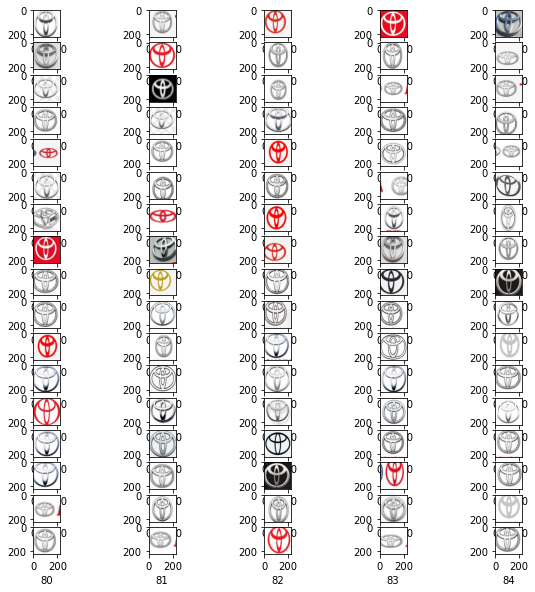

In [112]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Toyota"
ToyotaDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(ToyotaDF)

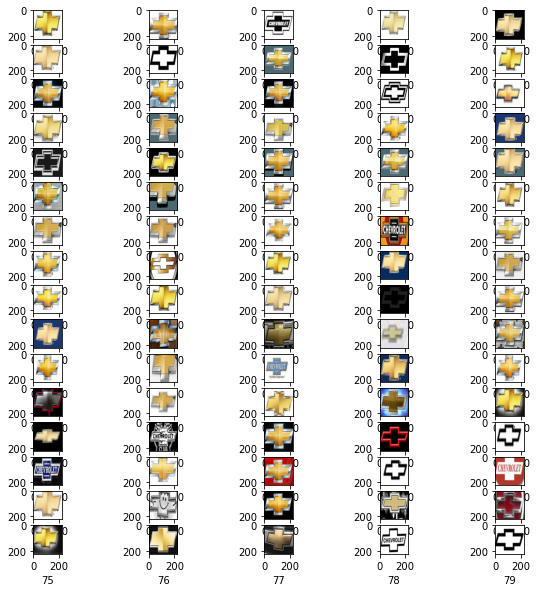

In [113]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Chevrolet"
ChevDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(ChevDF)

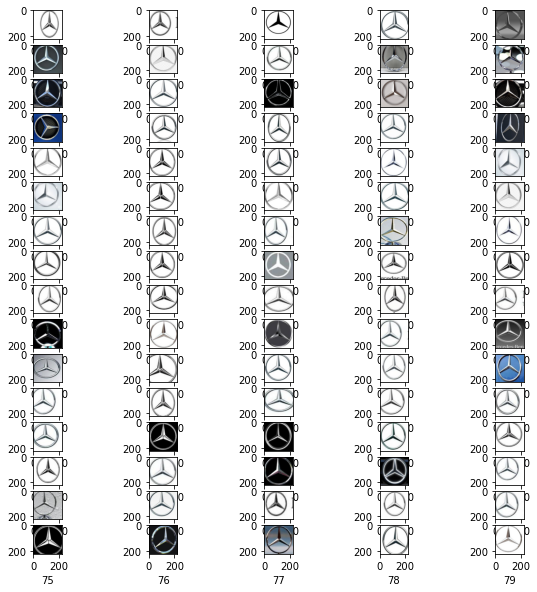

In [114]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Benz"
BenzDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(BenzDF)

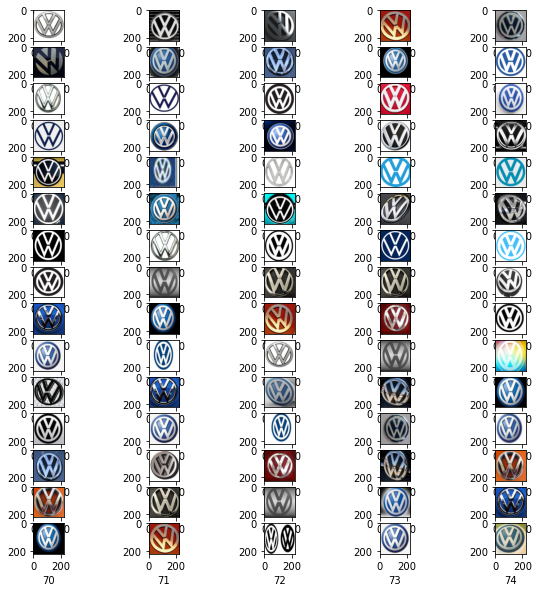

In [115]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Dataset\Volkswagon"
VolkswagonDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(VolkswagonDF)

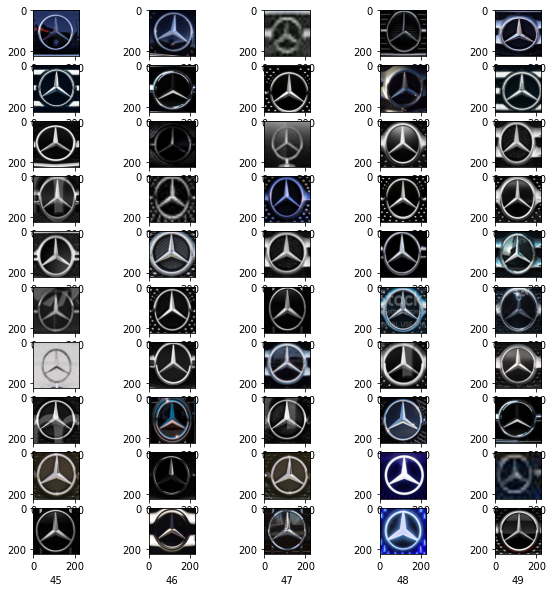

In [116]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Benz"
BenzRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(BenzRegionDF)

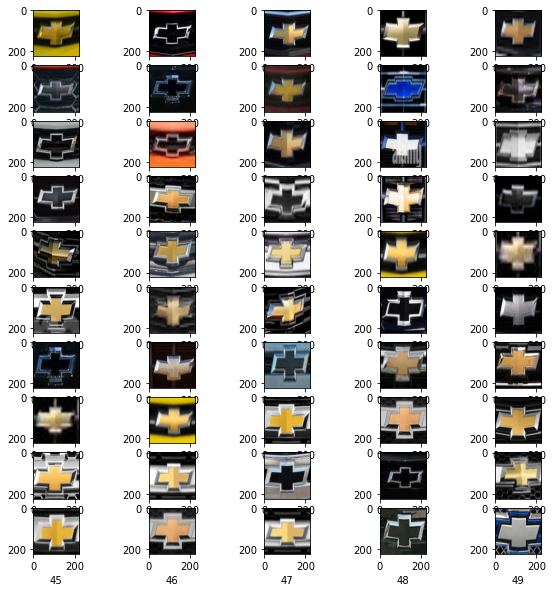

In [117]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Chevrolet"
ChevroletRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(ChevroletRegionDF)

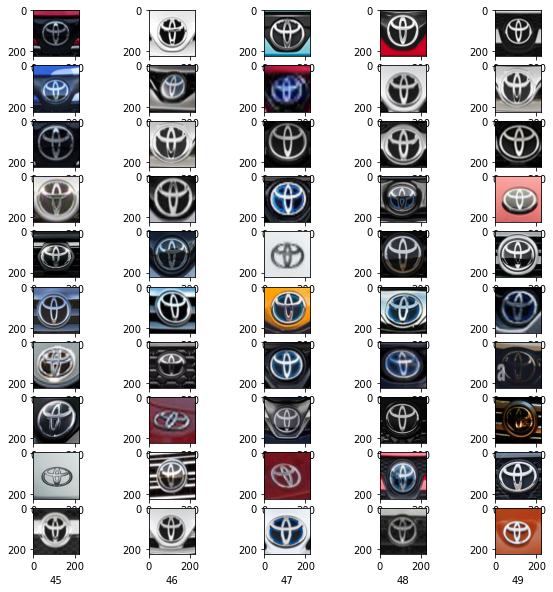

In [118]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Toyota"
ToyotaRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(ToyotaRegionDF)

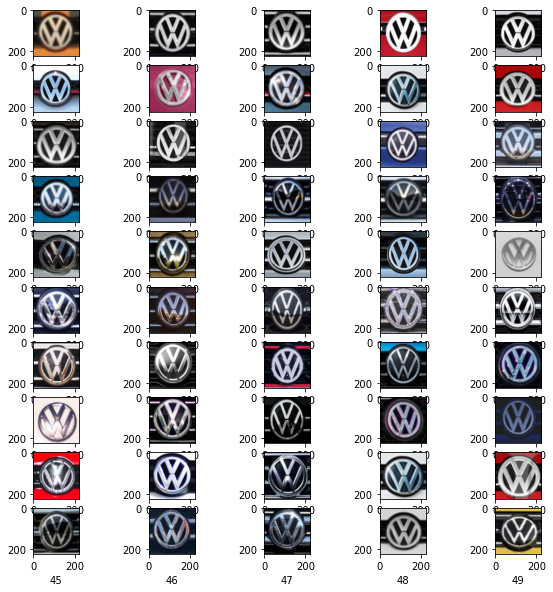

In [119]:
osDIR = r"G:\Users\Alex\Desktop\Classes\CSE 498 - Computer Vision\Project\Logo Annotation Dataset\Volkswagon"
VolkswagonRegionDF = parseXMLtoDF_Logo(osDIR)
displayBNDBOXinDF(VolkswagonRegionDF)

In [120]:
BenzDFdata = BenzDF[['filename', 'bndbox_img', 'objectType']]
ChevDFdata = ChevDF[['filename', 'bndbox_img', 'objectType']]
ToyotaDFdata = ToyotaDF[['filename', 'bndbox_img', 'objectType']]
VolkswagonDFdata = VolkswagonDF[['filename', 'bndbox_img', 'objectType']]

In [121]:
BenzRegionDFdata = BenzRegionDF[['filename', 'bndbox_img', 'objectType']]
ChevRegionDFdata = ChevroletRegionDF[['filename', 'bndbox_img', 'objectType']]
ToyotaRegionDFdata = ToyotaRegionDF[['filename', 'bndbox_img', 'objectType']]
VolkswagonRegionDFdata = VolkswagonRegionDF[['filename', 'bndbox_img', 'objectType']]

In [122]:
logoDF = pd.concat([BenzDFdata, BenzRegionDFdata, ChevDFdata, ChevRegionDFdata, 
                        VolkswagonDFdata, VolkswagonRegionDFdata,
                        ToyotaDFdata, ToyotaRegionDFdata])
#BentleyDFdata,  HyundaiDFdata, and Background

In [123]:
logoDF['objectType'].value_counts()

Toyota        136
Mercedes      135
Volkswagen    133
Chevrolet     132
Name: objectType, dtype: int64

In [125]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
logoDF['label'] = le.fit_transform(logoDF.objectType)
logoDF['label'].value_counts()

2    136
1    135
3    133
0    132
Name: label, dtype: int64

In [137]:
logo_append_images = []
logo_append_labels = []

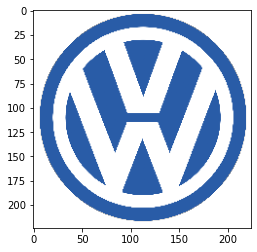

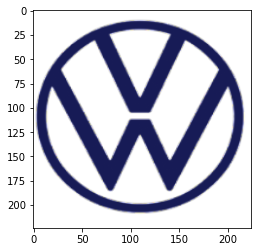

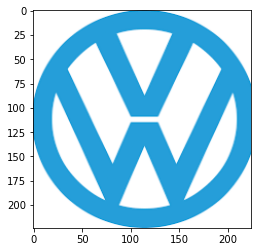

In [138]:
for i in range(logoDF['bndbox_img'].count()):
    if logoDF['bndbox_img'].iloc[i].shape == (224, 224, 3):
        logo_append_images.append(logoDF['bndbox_img'].iloc[i])
        logo_append_labels.append(1)
    else:
        plt.figure()
        plt.imshow(logoDF['bndbox_img'].iloc[i])

In [140]:
logo_train_images = np.stack(logo_append_images,axis=0)
print(logo_train_images.shape)

(533, 224, 224, 3)


In [141]:
X_new.shape

(1235, 224, 224, 3)

In [143]:
logo_train_labels = np.array(logo_append_labels)
logo_train_labels.shape

(533,)

In [144]:
logo_final_labels =  lenc.fit_transform(logo_train_labels)

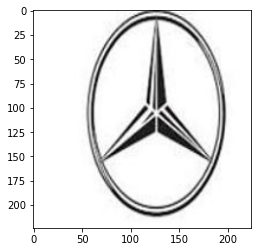

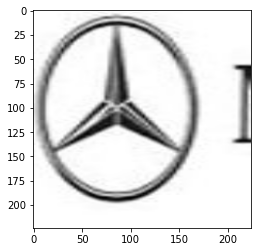

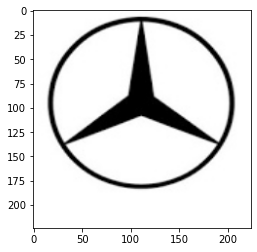

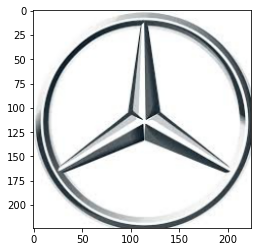

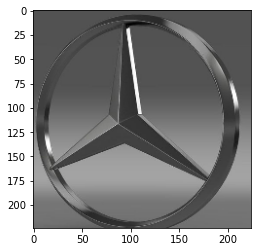

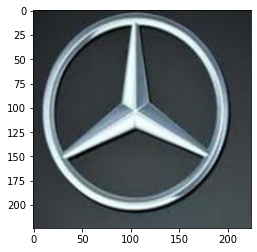

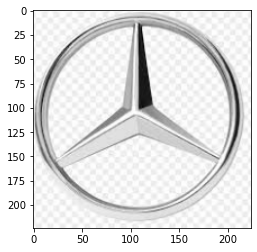

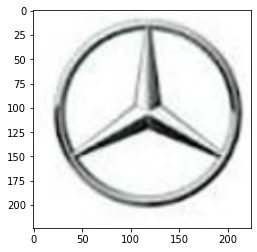

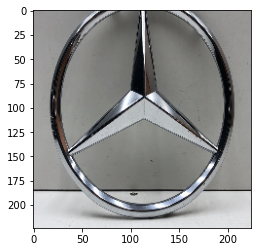

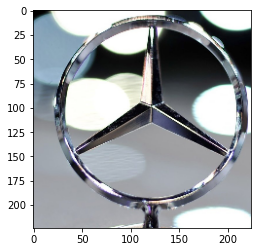

In [147]:
for i in range(0, 10):
    if(logo_append_labels[i] == 1):
        plt.figure()
        plt.imshow((logo_train_images[i]).astype('uint8'))

In [158]:
X_images = (X_new[:1235]).tolist()
X_labels = (y_new[:1235]).tolist()

In [159]:
for i in range(len(logo_train_images)):
    X_images.append(logo_train_images[i])
    X_labels.append(logo_append_labels[i])

In [160]:
X_new = np.array(X_images)
y_new = np.array(X_labels)
X_new.shape

# for i in range(len(X_images)):
#     if(X_images[i].shape != (224, 224, 3)):
#         print(i)

(1768, 224, 224, 3)

In [166]:
c2 = 0
f2 = 0
for i in range(len(y_new)):
    if y_new[i] == 1:
        c2 += 1
    elif y_new[i] == 0:
        f2 += 1
c2, f2

(718, 1050)

In [167]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [168]:
Y.shape

(1768, 2)

In [217]:
X_new2 = X_new[:1235]
Y2 = Y[:1235]

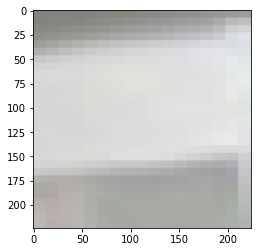

In [221]:
plt.imshow(X_new2[1234].astype('uint8'))